In [87]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import random

from codebase import utils as ut
from codebase import models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Exercise 1

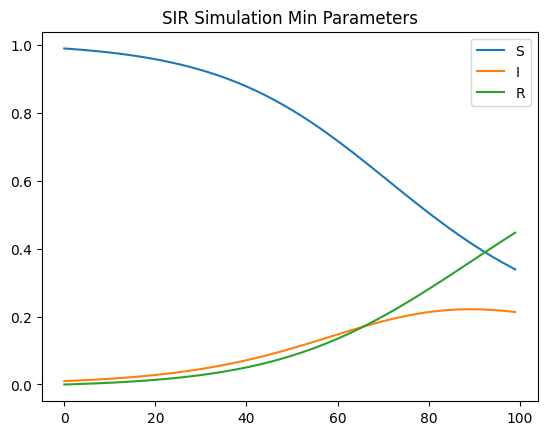

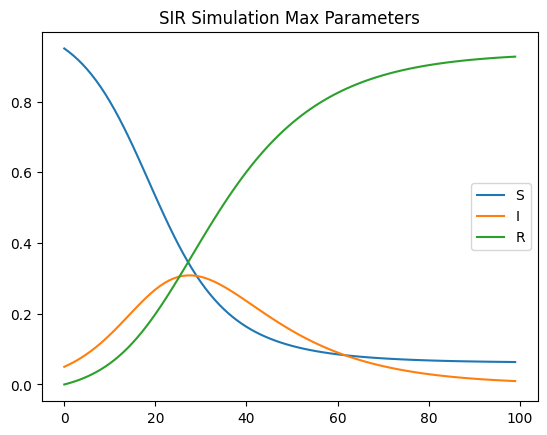

In [72]:
lam_min=0.095
lam_max=0.2
mu_min=0.04
mu_max=0.07
I0_min=0.01
I0_max=0.05

ut.plot_sir_single(lam_min, mu_min, I0_min, title='SIR Simulation Min Parameters')
ut.plot_sir_single(lam_max, mu_max, I0_max, title='SIR Simulation Max Parameters')

I tried to shift the 'peak' of the Infektions to the end with the minimal parameters and to the beginning with the max parameters 

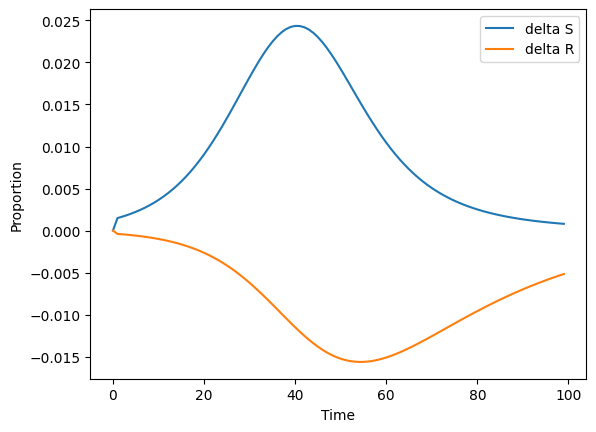

In [73]:
# parameters 
lam = 0.15
mu = 0.04
I_0 = 0.01
T = 100

# simulate
X = ut.simulate_sir_simple(lam, mu, I_0, T)

plt.plot(X[:, 0], label='delta S')
plt.plot(X[:, 1], label='delta R')
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.legend()
plt.show()

In [126]:
# define the prior distribution for the simulation parameters
def prior_distribution(num_samples = 1):
    lam = np.random.uniform(lam_min, lam_max, num_samples)
    mu = np.random.uniform(mu_min, mu_max, num_samples)
    I_0 = np.random.uniform(I0_min, I0_max, num_samples)
    return np.array(list(zip(lam, mu, I_0)))

### 1.3

In [ ]:
from codebase import models

%load_ext autoreload
%autoreload 2

In [148]:
def train_feedforward(model, simulation, priors, epochs, lr, days, training_set_size):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # train the model
    for epoch in range(epochs):
        samples = priors(training_set_size)
        X = np.array([simulation(*sample, days) for sample in samples])
        # print('X', X.shape)
        X = torch.tensor(X, dtype=torch.float32).to(device)
        X = X.view(X.size(0), -1)  # Flatten the time and feature dimensions
        samples = torch.tensor(samples, dtype=torch.float32).to(device)
        # print('samples', samples.shape)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        y_pred = model(X)
        # print('y_pred', y_pred.shape)
        # calculate the loss
        loss = loss_fn(y_pred, samples)
        # backward pass
        loss.backward()
        # optimize
        optimizer.step()
        # print the loss
        if epoch % days/2 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')

In [ ]:
# sample = prior_distribution() 
# ut.simulate_sir_simple(*sample, 10)

array([[ 0.        ,  0.        ],
       [ 0.00359117, -0.00118562],
       [ 0.00391538, -0.00129743],
       [ 0.00426534, -0.00141912],
       [ 0.00464241, -0.00155142],
       [ 0.00504789, -0.0016951 ],
       [ 0.00548294, -0.00185095],
       [ 0.00594862, -0.00201977],
       [ 0.00644576, -0.00220239],
       [ 0.00697496, -0.00239964]])

In [142]:
def evaluate(model, simulation, priors, epochs, batch_size):
    "nuber of samples in the test set is epochs*batch_size"
    loss_list = []
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        samples = priors(batch_size)
        X = np.array([simulation(*sample, 100) for sample in samples])
        X = torch.tensor(X, dtype=torch.float32).to(device)
        X = X.view(X.size(0), -1)
        samples = torch.tensor(samples, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            # forward pass
            y_pred = model(X)
            # calculate the loss
            loss = loss_fn(y_pred, samples)
            loss_list.append(loss.item())
    loss = np.mean(loss_list)
    return loss


In [141]:
# test run of the simulation 
model = models.FeedForward(200, 64, 2, 3).to(device)
print(model)

train_feedforward(model, ut.simulate_sir_simple, prior_distribution, epochs=50, lr=0.001, days=100, training_set_size=100)

FeedForward(
  (network): Sequential(
    (0): Linear(in_features=200, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)
Epoch 0, Loss 0.016860544681549072
Epoch 1, Loss 0.014464153908193111
Epoch 2, Loss 0.013525829650461674
Epoch 3, Loss 0.011962548829615116
Epoch 4, Loss 0.010148538276553154
Epoch 5, Loss 0.009691447019577026
Epoch 6, Loss 0.007906592451035976
Epoch 7, Loss 0.006835426669567823
Epoch 8, Loss 0.006083794869482517
Epoch 9, Loss 0.0051491218619048595
Epoch 10, Loss 0.004073030315339565
Epoch 11, Loss 0.0036508243065327406
Epoch 12, Loss 0.0029395350720733404
Epoch 13, Loss 0.002192871877923608
Epoch 14, Loss 0.0019059648038819432
Epoch 15, Loss 0.0015872224466875196
Epoch 16, Loss 0.0011740076588466763
Epoch 17, Loss 0.0008717675227671862
Epoch 18, Loss 0.0006707939319312572
Epoch 19, Loss 0.0005380939110182226
Epoch 20, Loss 0.00045488

In [138]:
# test the evaluation function
lam = 0.15
mu = 0.04
I_0 = 0.01
parameters = np.array([lam, mu, I_0])
X_test = ut.simulate_sir_simple(*parameters, 100) 
print("X_test", X_test.shape)

model = models.FeedForward(200, 64, 2, 3).to(device)
# evaluate the model
mse_evaluation(model, X_test.flatten(), parameters, 100)


X_test (100, 2)


0.021071307361125946

In [145]:
# # Parameter ranges
# hidden_size_list = [32, 64, 128, 256]
# num_layers_list = [2, 5, 10]
# epochs_list = [100, 500, 1000]
# batch_size_list = [32, 64]

# # Initialize lists for results
# hidden_size_results = []
# num_layers_results = []
# epochs_results = []
# batch_size_results = []

# # Standard parameters
# standard_hidden_size = 64
# standard_num_layers = 5
# standard_epochs = 100
# standard_epochs_eval = 20
# standard_batch_size = 64
# learning_rate = 0.001
# T = 100
# device = "cpu"  # assuming CPU for training

# # Vary hidden size
# print("Varying Hidden Size:")
# for hidden_size in hidden_size_list:
#     model = models.FeedForward(T * 2, hidden_size, standard_num_layers).to(device)
#     train_feedforward(model, ut.simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, T, standard_batch_size)  	        
#     loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, standard_batch_size)    
#     hidden_size_results.append(loss)
# print(f"Varying Hidden Size done: {hidden_size_results}")

# # Vary number of layers
# print("Varying Number of Layers:")
# for num_layers in num_layers_list:
#     model = models.FeedForward(T * 2, standard_hidden_size, num_layers).to(device)
#     train_feedforward(model, ut.simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, T, standard_batch_size)
#     loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, standard_batch_size)
#     num_layers_results.append(loss)
# print(f"Varying Number of Layers done: {num_layers_results}")

# # Vary number of epochs
# print("Varying Number of Epochs:")
# for epochs in epochs_list:
#     model = models.FeedForward(T * 2, standard_hidden_size, standard_num_layers).to(device)
#     train_feedforward(model, ut.simulate_sir_simple, prior_distribution, epochs, learning_rate, T, standard_batch_size)
#     loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, standard_batch_size)
#     epochs_results.append(loss)
# print(f"Varying Number of Epochs done: {epochs_results}")

# # Vary batch size
# print("Varying Batch Size:")
# for batch_size in batch_size_list:
#     model = models.FeedForward(T * 2, standard_hidden_size, standard_num_layers).to(device)
#     train_feedforward(model, ut.simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, T, batch_size)
#     loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, batch_size)
#     batch_size_results.append(loss)
# print(f"Varying Batch Size done: {batch_size_results}")


# # Print results
# print("\nHidden Size Results:", hidden_size_results)
# print("\nNumber of Layers Results:", num_layers_results)
# print("\nEpochs Results:", epochs_results)
# print("\nBatch Size Results:", batch_size_results)

Varying Hidden Size:
Epoch 0, Loss 0.013383723795413971
Epoch 1, Loss 0.012373730540275574
Epoch 2, Loss 0.011019784957170486
Epoch 3, Loss 0.010013556107878685
Epoch 4, Loss 0.009009669534862041
Epoch 5, Loss 0.008127644658088684
Epoch 6, Loss 0.007142259273678064
Epoch 7, Loss 0.006453080102801323
Epoch 8, Loss 0.005843549966812134
Epoch 9, Loss 0.004934150259941816
Epoch 10, Loss 0.0043353973887860775
Epoch 11, Loss 0.00365442200563848
Epoch 12, Loss 0.003282498801127076
Epoch 13, Loss 0.0026633823290467262
Epoch 14, Loss 0.00214586453512311
Epoch 15, Loss 0.0018031330546364188
Epoch 16, Loss 0.0014307239325717092
Epoch 17, Loss 0.001185236033052206
Epoch 18, Loss 0.0008779247291386127
Epoch 19, Loss 0.0006876061670482159
Epoch 20, Loss 0.0005630807718262076
Epoch 21, Loss 0.000568340125028044
Epoch 22, Loss 0.0003777772653847933
Epoch 23, Loss 0.00044463854283094406
Epoch 24, Loss 0.0004130580055061728
Epoch 25, Loss 0.0004830094112548977
Epoch 26, Loss 0.0005010719760321081
Epoch 

AttributeError: module 'codebase.models' has no attribute 'simulate_sir_simple'

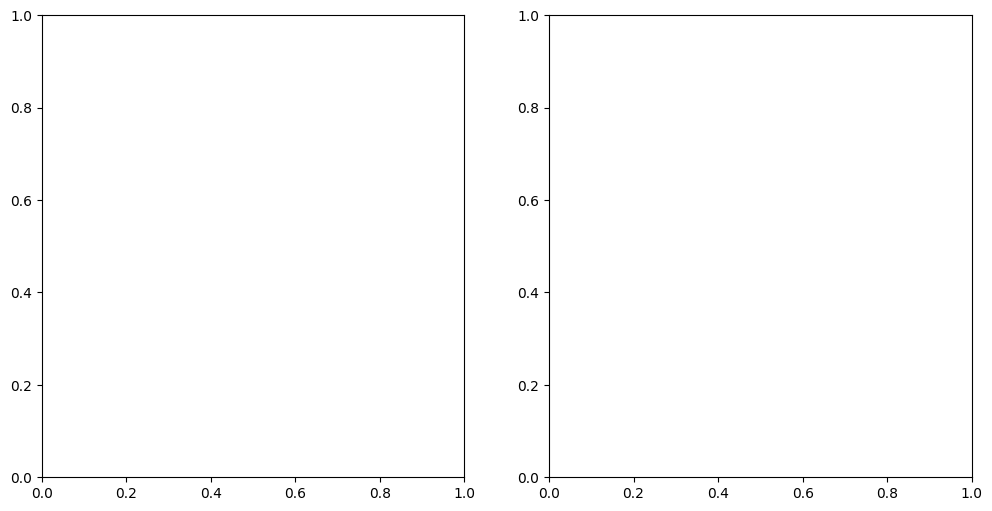

In [125]:
# define model test set 
lam = 0.15
mu = 0.04
I_0 = 0.01
parameters = np.array([lam, mu, I_0])
X_test = ut.simulate_sir_simple(*parameters, 100) 

# define hyperparameters 
hidden_sizes = [5, 10, 20, 50, 100]
layers = [1, 2, 3, 4, 5]
default_layers = 2
default_hidden_size = 10
lr = 0.001
epochs = 100
days = 100


# plot different model hyperparameters for the feed forward model

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
hidden_size_mse = []
layer_mse = []
for hidden_size in hidden_sizes:
    model = models.FeedForward(2, hidden_size, default_layers, 3).to(device)
    losses = train_feedforward(model, models.simulate_sir_simple, prior_distribution, epochs, lr, days)
    hidden_size_mse.append(mse_evaluation(model, X_test, parameters, days))

for layer in layers:
    model = models.FeedForward(2, default_hidden_size, layer, 3).to(device)
    losses = train_feedforward(model, models.simulate_sir_simple, prior_distribution, epochs, lr, days)
    layer_mse.append(mse_evaluation(model, X_test, parameters, days))


ax[0].plot(hidden_sizes, hidden_size_mse)
ax[0].set_xlabel('Hidden Size')
ax[0].set_ylabel('MSE')
ax[0].set_title('Hidden Size vs MSE')
ax[1].plot(layers, layer_mse)
ax[1].set_xlabel('Layers')
ax[1].set_ylabel('MSE')
ax[1].set_title('Layers vs MSE')
plt.show()




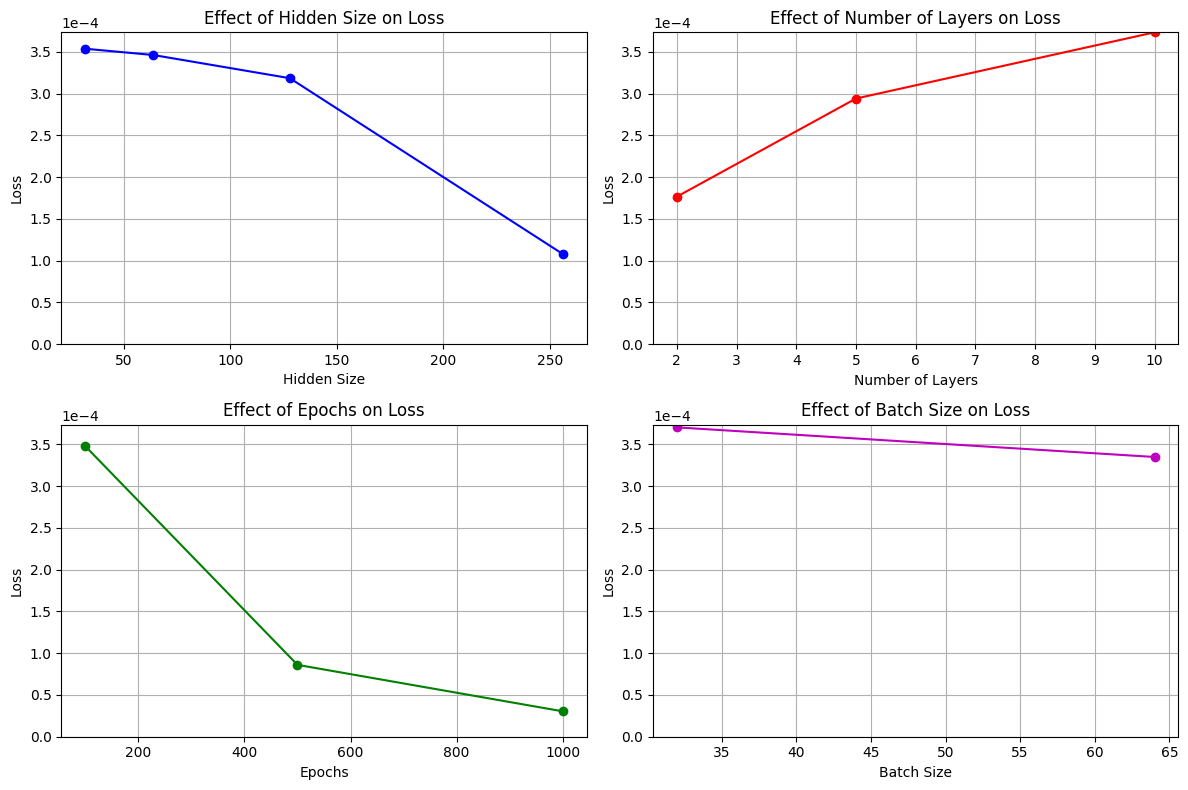

In [146]:
# import matplotlib.pyplot as plt

# # Set the ymin to 0 for all plots and use scientific notation for the y-axis
# y_min = 0
# y_max = max(max(hidden_size_results), max(num_layers_results), max(epochs_results), max(batch_size_results))

# # Create a figure with 2 rows and 2 columns to place the plots next to each other
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# # Plot results for varying hidden size
# axs[0, 0].plot(hidden_size_list, hidden_size_results, marker='o', color='b')
# axs[0, 0].set_title('Effect of Hidden Size on Loss')
# axs[0, 0].set_xlabel('Hidden Size')
# axs[0, 0].set_ylabel('Loss')
# axs[0, 0].grid(True)
# axs[0, 0].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
# axs[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# # Plot results for varying number of layers
# axs[0, 1].plot(num_layers_list, num_layers_results, marker='o', color='r')
# axs[0, 1].set_title('Effect of Number of Layers on Loss')
# axs[0, 1].set_xlabel('Number of Layers')
# axs[0, 1].set_ylabel('Loss')
# axs[0, 1].grid(True)
# axs[0, 1].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
# axs[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# # Plot results for varying number of epochs
# axs[1, 0].plot(epochs_list, epochs_results, marker='o', color='g')
# axs[1, 0].set_title('Effect of Epochs on Loss')
# axs[1, 0].set_xlabel('Epochs')
# axs[1, 0].set_ylabel('Loss')
# axs[1, 0].grid(True)
# axs[1, 0].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
# axs[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# # Plot results for varying batch size
# axs[1, 1].plot(batch_size_list, batch_size_results, marker='o', color='m')
# axs[1, 1].set_title('Effect of Batch Size on Loss')
# axs[1, 1].set_xlabel('Batch Size')
# axs[1, 1].set_ylabel('Loss')
# axs[1, 1].grid(True)
# axs[1, 1].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
# axs[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show all plots
# plt.show()


In [149]:
# Parameter ranges
hidden_size_list = [32, 64, 128, 256]
num_layers_list = [2, 5, 10]
epochs_list = [100, 500, 1000, 2000]
batch_size_list = [32, 64]

# Initialize lists for results
hidden_size_results = []
num_layers_results = []
epochs_results = []
batch_size_results = []

# Standard parameters
standard_hidden_size = 256
standard_num_layers = 5
standard_epochs = 500
standard_epochs_eval = 20
standard_batch_size = 64
learning_rate = 0.001
T = 100
device = "cpu"  # assuming CPU for training

# Vary hidden size
print("Varying Hidden Size:")
for hidden_size in hidden_size_list:
    model = models.FeedForward(T * 2, hidden_size, standard_num_layers).to(device)
    train_feedforward(model, ut.simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, T, standard_batch_size)  	        
    loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, standard_batch_size)    
    hidden_size_results.append(loss)
print(f"Varying Hidden Size done: {hidden_size_results}")

# Vary number of layers
print("Varying Number of Layers:")
for num_layers in num_layers_list:
    model = models.FeedForward(T * 2, standard_hidden_size, num_layers).to(device)
    train_feedforward(model, ut.simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, T, standard_batch_size)
    loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, standard_batch_size)
    num_layers_results.append(loss)
print(f"Varying Number of Layers done: {num_layers_results}")

# Vary number of epochs
print("Varying Number of Epochs:")
for epochs in epochs_list:
    model = models.FeedForward(T * 2, standard_hidden_size, standard_num_layers).to(device)
    train_feedforward(model, ut.simulate_sir_simple, prior_distribution, epochs, learning_rate, T, standard_batch_size)
    loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, standard_batch_size)
    epochs_results.append(loss)
print(f"Varying Number of Epochs done: {epochs_results}")

# Vary batch size
print("Varying Batch Size:")
for batch_size in batch_size_list:
    model = models.FeedForward(T * 2, standard_hidden_size, standard_num_layers).to(device)
    train_feedforward(model, ut.simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, T, batch_size)
    loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, standard_epochs_eval, batch_size)
    batch_size_results.append(loss)
print(f"Varying Batch Size done: {batch_size_results}")


# Print results
print("\nHidden Size Results:", hidden_size_results)
print("\nNumber of Layers Results:", num_layers_results)
print("\nEpochs Results:", epochs_results)
print("\nBatch Size Results:", batch_size_results)

Varying Hidden Size:
Epoch 0, Loss 0.025688039138913155
Epoch 100, Loss 0.0003556648443918675
Epoch 200, Loss 0.00011992426152573898
Epoch 300, Loss 0.00010295288666384295
Epoch 400, Loss 9.812520147534087e-05
Epoch 0, Loss 0.008911331184208393
Epoch 100, Loss 0.00019778496061917394
Epoch 200, Loss 9.546053479425609e-05
Epoch 300, Loss 6.579438195331022e-05
Epoch 400, Loss 4.397399607114494e-05
Epoch 0, Loss 0.017497744411230087
Epoch 100, Loss 0.00023461563978344202
Epoch 200, Loss 0.00010935517639154568
Epoch 300, Loss 8.826510020298883e-05
Epoch 400, Loss 8.39765343698673e-05
Epoch 0, Loss 0.01898304931819439
Epoch 100, Loss 0.00014343325165100396
Epoch 200, Loss 0.00011743659706553444
Epoch 300, Loss 7.127782009774819e-05
Epoch 400, Loss 4.5849137677578256e-05
Varying Hidden Size done: [9.284454863518476e-05, 4.056539610246546e-05, 4.224433560011676e-05, 3.959110435971525e-05]
Varying Number of Layers:
Epoch 0, Loss 0.01607467420399189
Epoch 100, Loss 0.000123147081467323
Epoch 200

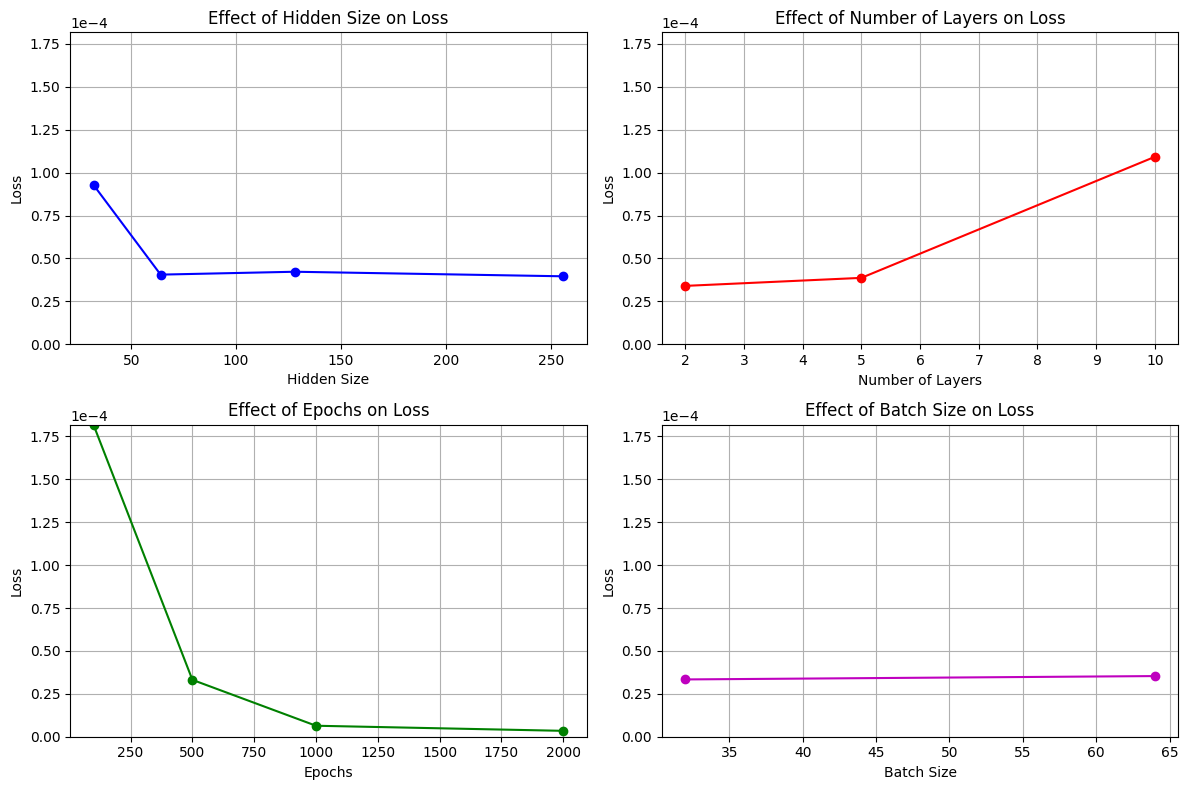

In [150]:
import matplotlib.pyplot as plt

# Set the ymin to 0 for all plots and use scientific notation for the y-axis
y_min = 0
y_max = max(max(hidden_size_results), max(num_layers_results), max(epochs_results), max(batch_size_results))

# Create a figure with 2 rows and 2 columns to place the plots next to each other
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot results for varying hidden size
axs[0, 0].plot(hidden_size_list, hidden_size_results, marker='o', color='b')
axs[0, 0].set_title('Effect of Hidden Size on Loss')
axs[0, 0].set_xlabel('Hidden Size')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Plot results for varying number of layers
axs[0, 1].plot(num_layers_list, num_layers_results, marker='o', color='r')
axs[0, 1].set_title('Effect of Number of Layers on Loss')
axs[0, 1].set_xlabel('Number of Layers')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Plot results for varying number of epochs
axs[1, 0].plot(epochs_list, epochs_results, marker='o', color='g')
axs[1, 0].set_title('Effect of Epochs on Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Plot results for varying batch size
axs[1, 1].plot(batch_size_list, batch_size_results, marker='o', color='m')
axs[1, 1].set_title('Effect of Batch Size on Loss')
axs[1, 1].set_xlabel('Batch Size')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_ylim(y_min, y_max)  # Set the same y-limits for all plots
axs[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Use scientific notation

# Adjust layout for better spacing
plt.tight_layout()

# Show all plots
plt.show()


In [152]:
# Standard parameters set by best model
standard_hidden_size = 64
standard_num_layers = 2
standard_epochs = 1000
standard_batch_size = 32
learning_rate = 0.001
device = "cpu"  # assuming CPU for training

model = models.FeedForward(100 * 2, standard_hidden_size, standard_num_layers).to(device)
train_feedforward(model, ut.simulate_sir_simple, prior_distribution, standard_epochs, learning_rate, T, standard_batch_size)
loss = evaluate(model, ut.simulate_sir_simple, prior_distribution, 10, standard_batch_size)
print(f"Test set loss is: {loss}")

Epoch 0, Loss 0.026463039219379425
Epoch 100, Loss 0.00017168920021504164
Epoch 200, Loss 0.00011017190990969539
Epoch 300, Loss 0.00010548088903306052
Epoch 400, Loss 8.790480205789208e-05
Epoch 500, Loss 8.965028246166185e-05
Epoch 600, Loss 7.120626833057031e-05
Epoch 700, Loss 5.179327490623109e-05
Epoch 800, Loss 3.1278093956643716e-05
Epoch 900, Loss 3.355823355377652e-05
Test set loss is: 3.616099074861267e-05


In [153]:
def train_conditional_inn(CondRealNVPmodel, FeatureDetectormodel, simulation, priors, epochs, lr, batch_size):
    optimizer = torch.optim.Adam(
    list(CondRealNVPmodel.parameters()) + list(FeatureDetectormodel.parameters()),
    lr=lr)

    for epoch in range(epochs):
        CondRealNVPmodel.train()
        FeatureDetectormodel.train()    
        samples = priors(batch_size)
        X = np.array([simulation(*sample, 100) for sample in samples])
        X = torch.tensor(X, dtype=torch.float32).to(device)
        X = X.view(X.size(0), -1)  # Flatten the time and feature dimensions
        features = FeatureDetectormodel(X)
        samples = torch.tensor(samples, dtype=torch.float32).to(device)

        z, log_det = CondRealNVPmodel(samples, features)
        log_prob = -0.5 * (z ** 2).sum(dim=1)  # Log of the Gaussian
        loss = -(log_prob + log_det).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


In [154]:
h_model = model.FeatureDetector(200, 64, 10).to(device) #(input_size, hidden_size, num_layers)
cNF = model.CondRealNVP(3, 64, 3, 10, 64).to(device) #(input_size, hidden_size, num_hidden_layers, blocks, condition_size)

train_conditional_inn(cNF, h_model, ut.simulate_sir_simple, prior_distribution, 1000, 0.0001, 128)

AttributeError: 'FeedForward' object has no attribute 'FeatureDetector'